In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-10-05 11:37:02'

# Pre-train Binary mnist models, prune without training

## Dropout utilities are initialized to 0s

In [1]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.ticker as ticker

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [3]:
from cycler import cycler

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.7
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rc("axes", prop_cycle=standard_cycler)


In [4]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='rlai',
                                            password=os.environ['gcpswd'],
                                            host='35.203.104.151',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [5]:
db1 = DbAccessor('hshah1_0813_binary_mnist_offline_pruner_sweep', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db1.conn)

,name,dropout_estimator_iterations,dropout_perc,min_synapses_to_keep,perc_prune,prune_interval,pruner_type,seed,start_pruning_at,step_size,steps,trace_decay_rate,trained_model_path,training_points,utility_to_keep,run
0,0813_binary_mnist_offline_pruner_sweep,1,0.0050,500,0.0,10000,random,0,10000,0,50000000,0.999999,trained_models/mnist_binary_pretrained_,60000,0,0
1,0813_binary_mnist_offline_pruner_sweep,1,0.0050,500,0.0,10000,none,0,10000,0,50000000,0.999999,trained_models/mnist_binary_pretrained_,60000,0,1
2,0813_binary_mnist_offline_pruner_sweep,1,0.0050,500,0.0,10000,weight_magnitude,0,10000,0,50000000,0.999999,trained_models/mnist_binary_pretrained_,60000,0,2
3,0813_binary_mnist_offline_pruner_sweep,1,0.0050,500,0.0,10000,random,1,10000,0,50000000,0.999999,trained_models/mnist_binary_pretrained_,60000,0,3
4,0813_binary_mnist_offline_pruner_sweep,1,0.0050,500,0.0,10000,none,1,10000,0,50000000,0.999999,trained_models/mnist_binary_pretrained_,60000,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,0813_binary_mnist_offline_pruner_sweep,1,0.0010,500,0.0,10000,dropout_utility_estimator,2,10000,0,50000000,0.999990,trained_models/mnist_binary_pretrained_,60000,0,2295
426,0813_binary_mnist_offline_pruner_sweep,1,0.0005,500,0.0,10000,dropout_utility_estimator,2,10000,0,50000000,0.999990,trained_models/mnist_binary_pretrained_,60000,0,2296
427,0813_binary_mnist_offline_pruner_sweep,1,0.0001,500,0.0,10000,dropout_utility_estimator,2,10000,0,50000000,0.999990,trained_models/mnist_binary_pretrained_,60000,0,2297
428,0813_binary_mnist_offline_pruner_sweep,1,0.0100,500,0.0,10000,dropout_utility_estimator,3,10000,0,50000000,0.999990,trained_models/mnist_binary_pretrained_,60000,0,2298


In [6]:
db2 = DbAccessor('hshah1_0814_binary_mnist_dropout_init_0', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db2.conn)

,name,dropout_estimator_iterations,dropout_perc,min_synapses_to_keep,perc_prune,prune_interval,pruner_type,seed,start_pruning_at,step_size,steps,trace_decay_rate,trained_model_path,training_points,utility_to_keep,run
0,0814_binary_mnist_dropout_init_0,1,0.0100,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.990000,trained_models/mnist_binary_pretrained_,60000,0,0
1,0814_binary_mnist_dropout_init_0,1,0.0050,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.990000,trained_models/mnist_binary_pretrained_,60000,0,1
2,0814_binary_mnist_dropout_init_0,1,0.0025,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.990000,trained_models/mnist_binary_pretrained_,60000,0,2
3,0814_binary_mnist_dropout_init_0,1,0.0010,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.990000,trained_models/mnist_binary_pretrained_,60000,0,3
4,0814_binary_mnist_dropout_init_0,1,0.0005,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.990000,trained_models/mnist_binary_pretrained_,60000,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0814_binary_mnist_dropout_init_0,1,0.0050,500,0.0,10000,dropout_utility_estimator,9,10000,0,50000000,0.999999,trained_models/mnist_binary_pretrained_,60000,0,295
296,0814_binary_mnist_dropout_init_0,1,0.0025,500,0.0,10000,dropout_utility_estimator,9,10000,0,50000000,0.999999,trained_models/mnist_binary_pretrained_,60000,0,296
297,0814_binary_mnist_dropout_init_0,1,0.0010,500,0.0,10000,dropout_utility_estimator,9,10000,0,50000000,0.999999,trained_models/mnist_binary_pretrained_,60000,0,297
298,0814_binary_mnist_dropout_init_0,1,0.0005,500,0.0,10000,dropout_utility_estimator,9,10000,0,50000000,0.999999,trained_models/mnist_binary_pretrained_,60000,0,298


In [7]:
db3 = DbAccessor('hshah1_0819_binary_mnist_dropout_vary_fwd', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db3.conn)

,name,dropout_estimator_iterations,dropout_perc,min_synapses_to_keep,perc_prune,prune_interval,pruner_type,seed,start_pruning_at,step_size,steps,trace_decay_rate,trained_model_path,training_points,utility_to_keep,run
0,0819_binary_mnist_dropout_vary_fwd,2,0.0100,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.99000,trained_models/mnist_binary_pretrained_,60000,0,0
1,0819_binary_mnist_dropout_vary_fwd,4,0.0100,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.99000,trained_models/mnist_binary_pretrained_,60000,0,1
2,0819_binary_mnist_dropout_vary_fwd,2,0.0050,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.99000,trained_models/mnist_binary_pretrained_,60000,0,2
3,0819_binary_mnist_dropout_vary_fwd,4,0.0050,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.99000,trained_models/mnist_binary_pretrained_,60000,0,3
4,0819_binary_mnist_dropout_vary_fwd,2,0.0010,500,0.0,10000,dropout_utility_estimator,0,10000,0,50000000,0.99000,trained_models/mnist_binary_pretrained_,60000,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0819_binary_mnist_dropout_vary_fwd,4,0.0050,500,0.0,10000,dropout_utility_estimator,9,10000,0,50000000,0.99999,trained_models/mnist_binary_pretrained_,60000,0,315
316,0819_binary_mnist_dropout_vary_fwd,2,0.0010,500,0.0,10000,dropout_utility_estimator,9,10000,0,50000000,0.99999,trained_models/mnist_binary_pretrained_,60000,0,316
317,0819_binary_mnist_dropout_vary_fwd,4,0.0010,500,0.0,10000,dropout_utility_estimator,9,10000,0,50000000,0.99999,trained_models/mnist_binary_pretrained_,60000,0,317
318,0819_binary_mnist_dropout_vary_fwd,2,0.0001,500,0.0,10000,dropout_utility_estimator,9,10000,0,50000000,0.99999,trained_models/mnist_binary_pretrained_,60000,0,318


In [8]:
from scipy.ndimage.filters import uniform_filter1d
def moving_avg(x, n):
    return uniform_filter1d(x, size=n)
    #cumsum = np.cumsum(np.insert(x, 0, 0)) 
    #return (cumsum[n:] - cumsum[:-n]) / float(n)

In [9]:
def plt_with_err(db, color, label=None, conditions=[], table='test_metrics',
                 plot_conf=True, linestyle='-', nolabel=False, linewidth=None,
                 col=None, smoothing_n=1, begin_at=0):
    if col is None:
        col = 'error'
    if label is None:
        label = ''
    
    runs = []
    invalid_count = 0
    condition_str = ""
    condition_str = ""
    for c in conditions:
        if condition_str != "":
            condition_str += 'and '
        condition_str += f'{c[0]} = "{c[1]}" '
    v = pd.read_sql(f'select step,  avg(error), std(error)/sqrt(count(*)), count(*) from runs join error_table where {condition_str} and error_table.run = runs.run group by step', db.conn).values
    v = v[begin_at:] #truncate initial entries
    v[:,1] = moving_avg(v[:,1], smoothing_n) # smooth out the errrrrrrrs
    v[:,2] = v[:,2] * 2 # 2 standard errs
    total_runs = int(v[:,3][-1])
    print(f'\t Found {total_runs} valid runs for {conditions}')

    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(v[:,0], v[:,1], color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(v[:,0], v[:,1], label=f"{label} | valid runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(v[:,0], v[:,1]-v[:,2], v[:,1]+v[:,2], alpha=0.10, color=color, edgecolor=None)
    return True

In [10]:
def plt_acc_with_err(db, color, label=None, conditions=[], table='test_metrics',
                 plot_conf=True, linestyle='-', nolabel=False, linewidth=None,
                 col=None, smoothing_n=1, begin_at=0):
    if col is None:
        col = 'error'
    if label is None:
        label = ''
    
    runs = []
    invalid_count = 0
    condition_str = ""
    condition_str = ""
    for c in conditions:
        if condition_str != "":
            condition_str += 'and '
        condition_str += f'{c[0]} = "{c[1]}" '
    v = pd.read_sql(f'select step,  avg(accuracy), std(accuracy)/sqrt(count(*)), count(*) from runs join error_table where {condition_str} and error_table.run = runs.run group by step', db.conn).values
    v = v[begin_at:] #truncate initial entries
    v[:,1] = moving_avg(v[:,1], smoothing_n) # smooth out the errrrrrrrs
    v[:,2] = v[:,2] * 2 # 2 standard errs
    total_runs = int(v[:,3][-1])
    print(f'\t Found {total_runs} valid runs for {conditions}')

    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(v[:,0], v[:,1], color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(v[:,0], v[:,1], label=f"{label} | valid runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(v[:,0], v[:,1]-v[:,2], v[:,1]+v[:,2], alpha=0.16, color=color, edgecolor=None)
    return True

	 Found 10 valid runs for [['pruner_type', 'none']]
	 Found 10 valid runs for [['pruner_type', 'random']]
	 Found 9 valid runs for [['pruner_type', 'utility_propagation'], ['trace_decay_rate', 0.99999]]
	 Found 10 valid runs for [['pruner_type', 'weight_magnitude']]
	 Found 10 valid runs for [['pruner_type', 'activation_trace'], ['trace_decay_rate', 0.999999]]
	 Found 9 valid runs for [['pruner_type', 'dropout_utility_estimator'], ['dropout_perc', 0.01], ['trace_decay_rate', 0.99999]]
	 Found 10 valid runs for [['pruner_type', 'dropout_utility_estimator'], ['dropout_perc', 0.01], ['trace_decay_rate', 0.99999], ['dropout_estimator_iterations', 2]]
	 Found 10 valid runs for [['pruner_type', 'dropout_utility_estimator'], ['dropout_perc', 0.01], ['trace_decay_rate', 0.99999], ['dropout_estimator_iterations', 4]]


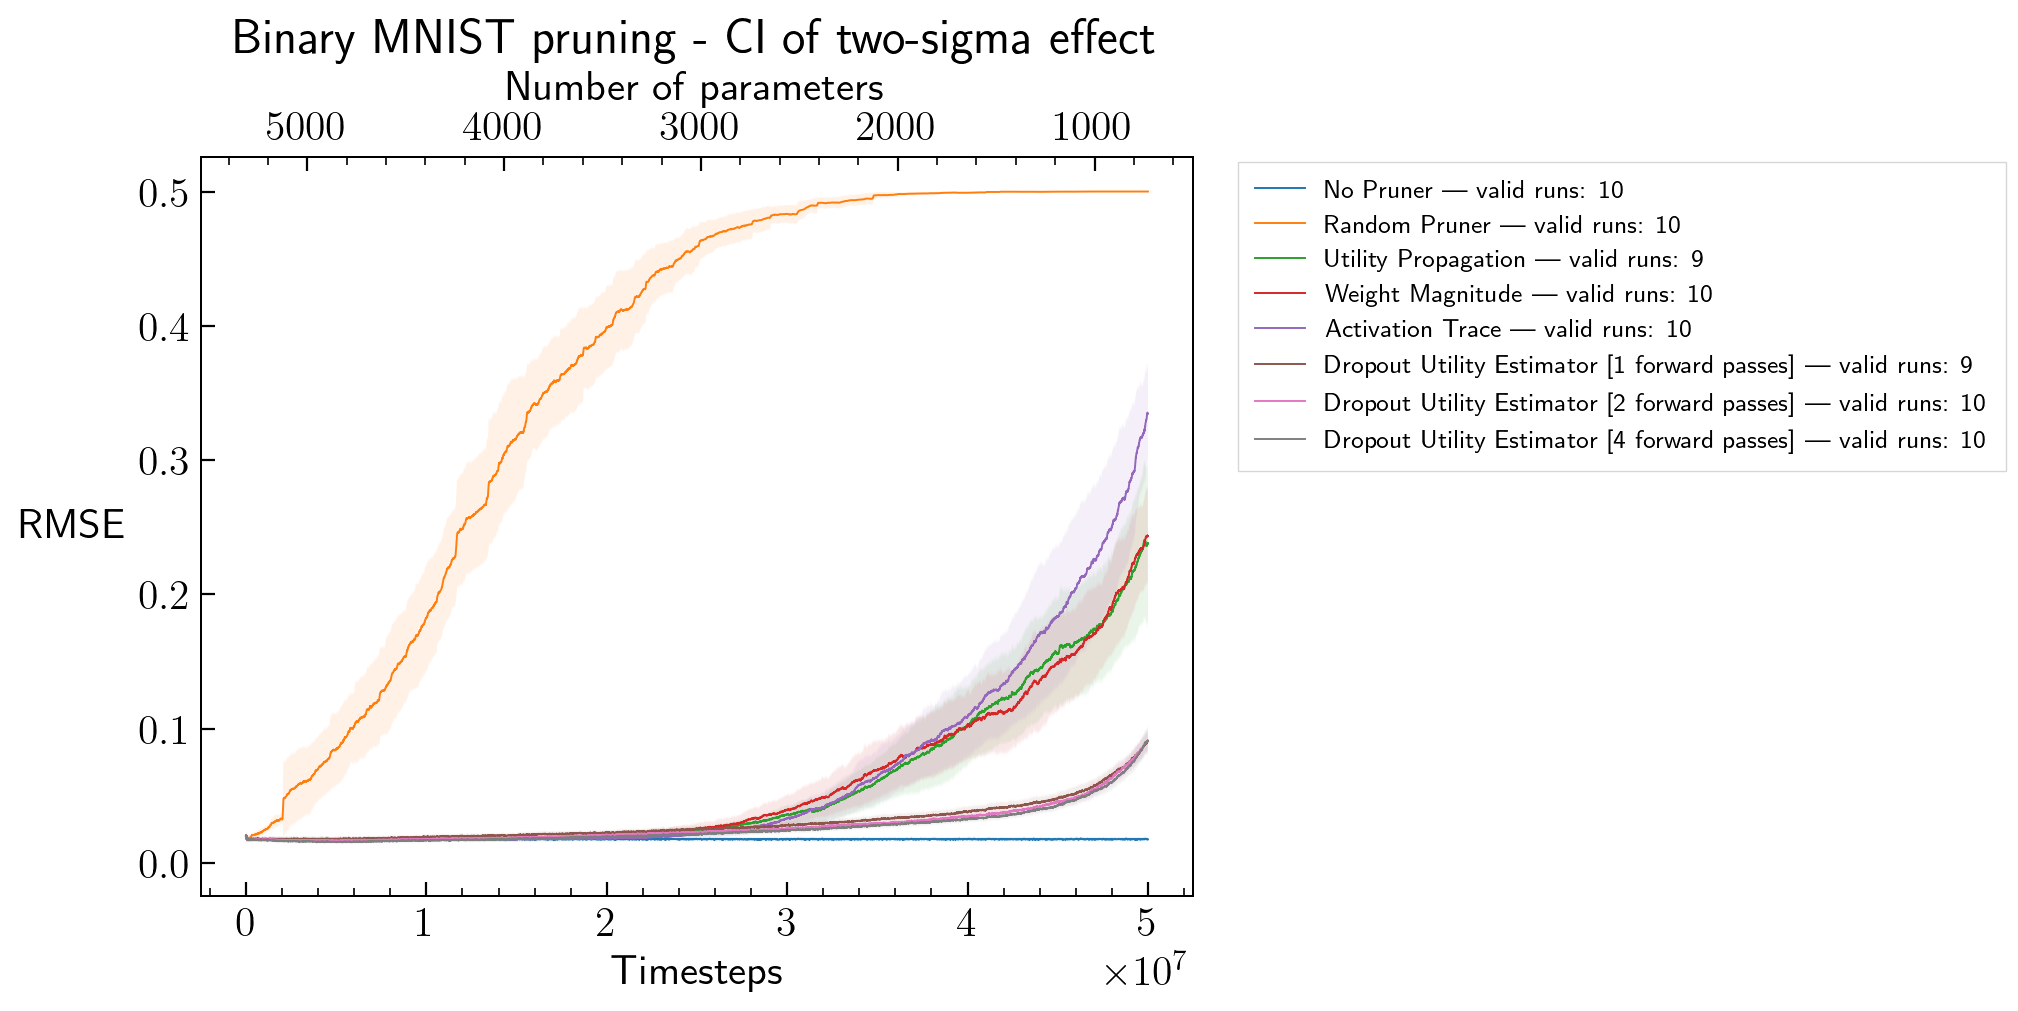

In [11]:

plt_name = f'Binary MNIST pruning - CI of two-sigma effect'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('RMSE', rotation="horizontal", ha="right", ma="center", va="center")
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

linewidth = 0.7
begin_at = 5
smoothing_n = 50
colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
conditions = [["pruner_type", "none"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'No Pruner', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "random"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Random Pruner', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)


color_idx += 1
conditions = [["pruner_type", "utility_propagation"],
              ["trace_decay_rate", 0.99999]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Utility Propagation', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)


color_idx += 1
conditions = [["pruner_type", "weight_magnitude"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Weight Magnitude', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "activation_trace"],
              ["trace_decay_rate", 0.999999]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Activation Trace', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "dropout_utility_estimator"],
              ["dropout_perc", 0.01],
              ["trace_decay_rate", 0.99999]]

plt_with_err(db2, 
             colors[color_idx], 
             f'Dropout Utility Estimator [1 forward passes]', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "dropout_utility_estimator"],
              ["dropout_perc", 0.01],
              ["trace_decay_rate", 0.99999],
              ["dropout_estimator_iterations", 2]]

plt_with_err(db3, 
             colors[color_idx], 
             f'Dropout Utility Estimator [2 forward passes]', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "dropout_utility_estimator"],
              ["dropout_perc", 0.01],
              ["trace_decay_rate", 0.99999],
              ["dropout_estimator_iterations", 4]]

plt_with_err(db3, 
             colors[color_idx], 
             f'Dropout Utility Estimator [4 forward passes]', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")

frame = legend.get_frame()

frame.set_linewidth(0.5)
frame.set_boxstyle('Square')

ax2 = axs.twiny()
ax2.plot(pd.read_sql(f'select param_schedule from error_table where run=0 ', db1.conn).values[begin_at:,0], np.zeros(50000-begin_at), color="None")
ax2.set_xlabel("Number of parameters")
#ax2.xaxis.set_ticks(np.arange(8800, 99, -300))
ax2.minorticks_on()
ax2.set_xlim(left=5540, right=500)
plt.yscale('linear')
#fig.axes[0].set_ylim(top=2.5)
#plt.savefig('figures/plt_err_all_fixed_newl2.svg', bbox_inches='tight', transparent=True)
plt.show()

### same as above but in log scale

	 Found 10 valid runs for [['pruner_type', 'none']]
	 Found 10 valid runs for [['pruner_type', 'random']]
	 Found 9 valid runs for [['pruner_type', 'utility_propagation'], ['trace_decay_rate', 0.99999]]
	 Found 10 valid runs for [['pruner_type', 'weight_magnitude']]
	 Found 10 valid runs for [['pruner_type', 'activation_trace'], ['trace_decay_rate', 0.999999]]
	 Found 9 valid runs for [['pruner_type', 'dropout_utility_estimator'], ['dropout_perc', 0.01], ['trace_decay_rate', 0.99999]]
	 Found 10 valid runs for [['pruner_type', 'dropout_utility_estimator'], ['dropout_perc', 0.01], ['trace_decay_rate', 0.99999], ['dropout_estimator_iterations', 2]]
	 Found 10 valid runs for [['pruner_type', 'dropout_utility_estimator'], ['dropout_perc', 0.01], ['trace_decay_rate', 0.99999], ['dropout_estimator_iterations', 4]]


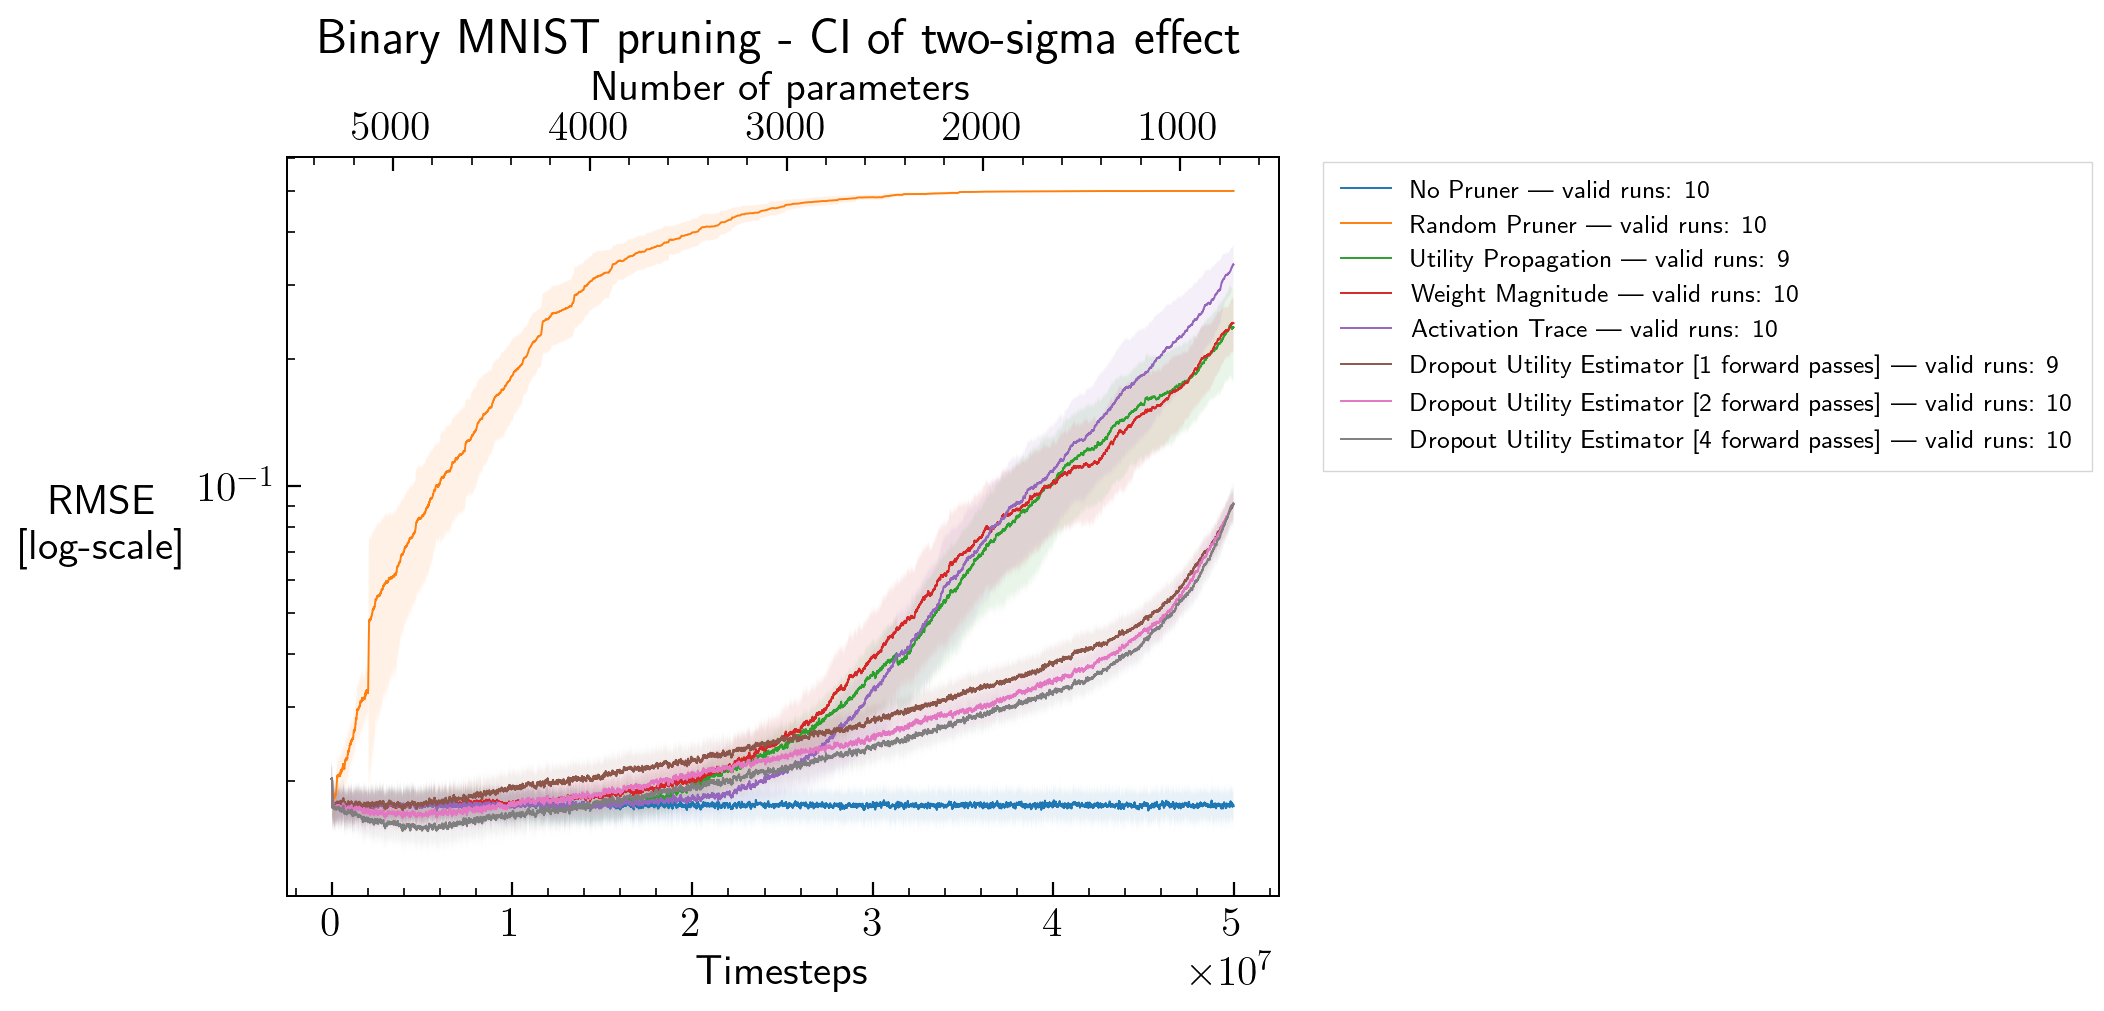

In [12]:

plt_name = f'Binary MNIST pruning - CI of two-sigma effect'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('RMSE \n [log-scale]', rotation="horizontal", ha="right", ma="center", va="center")
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

linewidth = 0.7
begin_at = 5
smoothing_n = 50
colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
conditions = [["pruner_type", "none"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'No Pruner', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "random"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Random Pruner', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)


color_idx += 1
conditions = [["pruner_type", "utility_propagation"],
              ["trace_decay_rate", 0.99999]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Utility Propagation', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)


color_idx += 1
conditions = [["pruner_type", "weight_magnitude"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Weight Magnitude', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "activation_trace"],
              ["trace_decay_rate", 0.999999]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Activation Trace', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "dropout_utility_estimator"],
              ["dropout_perc", 0.01],
              ["trace_decay_rate", 0.99999]]

plt_with_err(db2, 
             colors[color_idx], 
             f'Dropout Utility Estimator [1 forward passes]', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "dropout_utility_estimator"],
              ["dropout_perc", 0.01],
              ["trace_decay_rate", 0.99999],
              ["dropout_estimator_iterations", 2]]

plt_with_err(db3, 
             colors[color_idx], 
             f'Dropout Utility Estimator [2 forward passes]', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "dropout_utility_estimator"],
              ["dropout_perc", 0.01],
              ["trace_decay_rate", 0.99999],
              ["dropout_estimator_iterations", 4]]

plt_with_err(db3, 
             colors[color_idx], 
             f'Dropout Utility Estimator [4 forward passes]', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")

frame = legend.get_frame()

frame.set_linewidth(0.5)
frame.set_boxstyle('Square')

ax2 = axs.twiny()
ax2.plot(pd.read_sql(f'select param_schedule from error_table where run=0 ', db1.conn).values[begin_at:,0], np.zeros(50000-begin_at), color="None")
ax2.set_xlabel("Number of parameters")
#ax2.xaxis.set_ticks(np.arange(8800, 99, -300))
ax2.minorticks_on()
ax2.set_xlim(left=5540, right=500)
plt.yscale('log')
#fig.axes[0].set_ylim(top=2.5)
#plt.savefig('figures/plt_err_all_fixed_newl2.svg', bbox_inches='tight', transparent=True)
plt.show()

### Replot without the multi fwds

	 Found 10 valid runs for [['pruner_type', 'none']]
	 Found 10 valid runs for [['pruner_type', 'random']]
	 Found 9 valid runs for [['pruner_type', 'utility_propagation'], ['trace_decay_rate', 0.99999]]
	 Found 10 valid runs for [['pruner_type', 'weight_magnitude']]
	 Found 10 valid runs for [['pruner_type', 'activation_trace'], ['trace_decay_rate', 0.999999]]
	 Found 10 valid runs for [['pruner_type', 'dropout_utility_estimator'], ['dropout_perc', 0.01], ['trace_decay_rate', 0.99999], ['dropout_estimator_iterations', 4]]


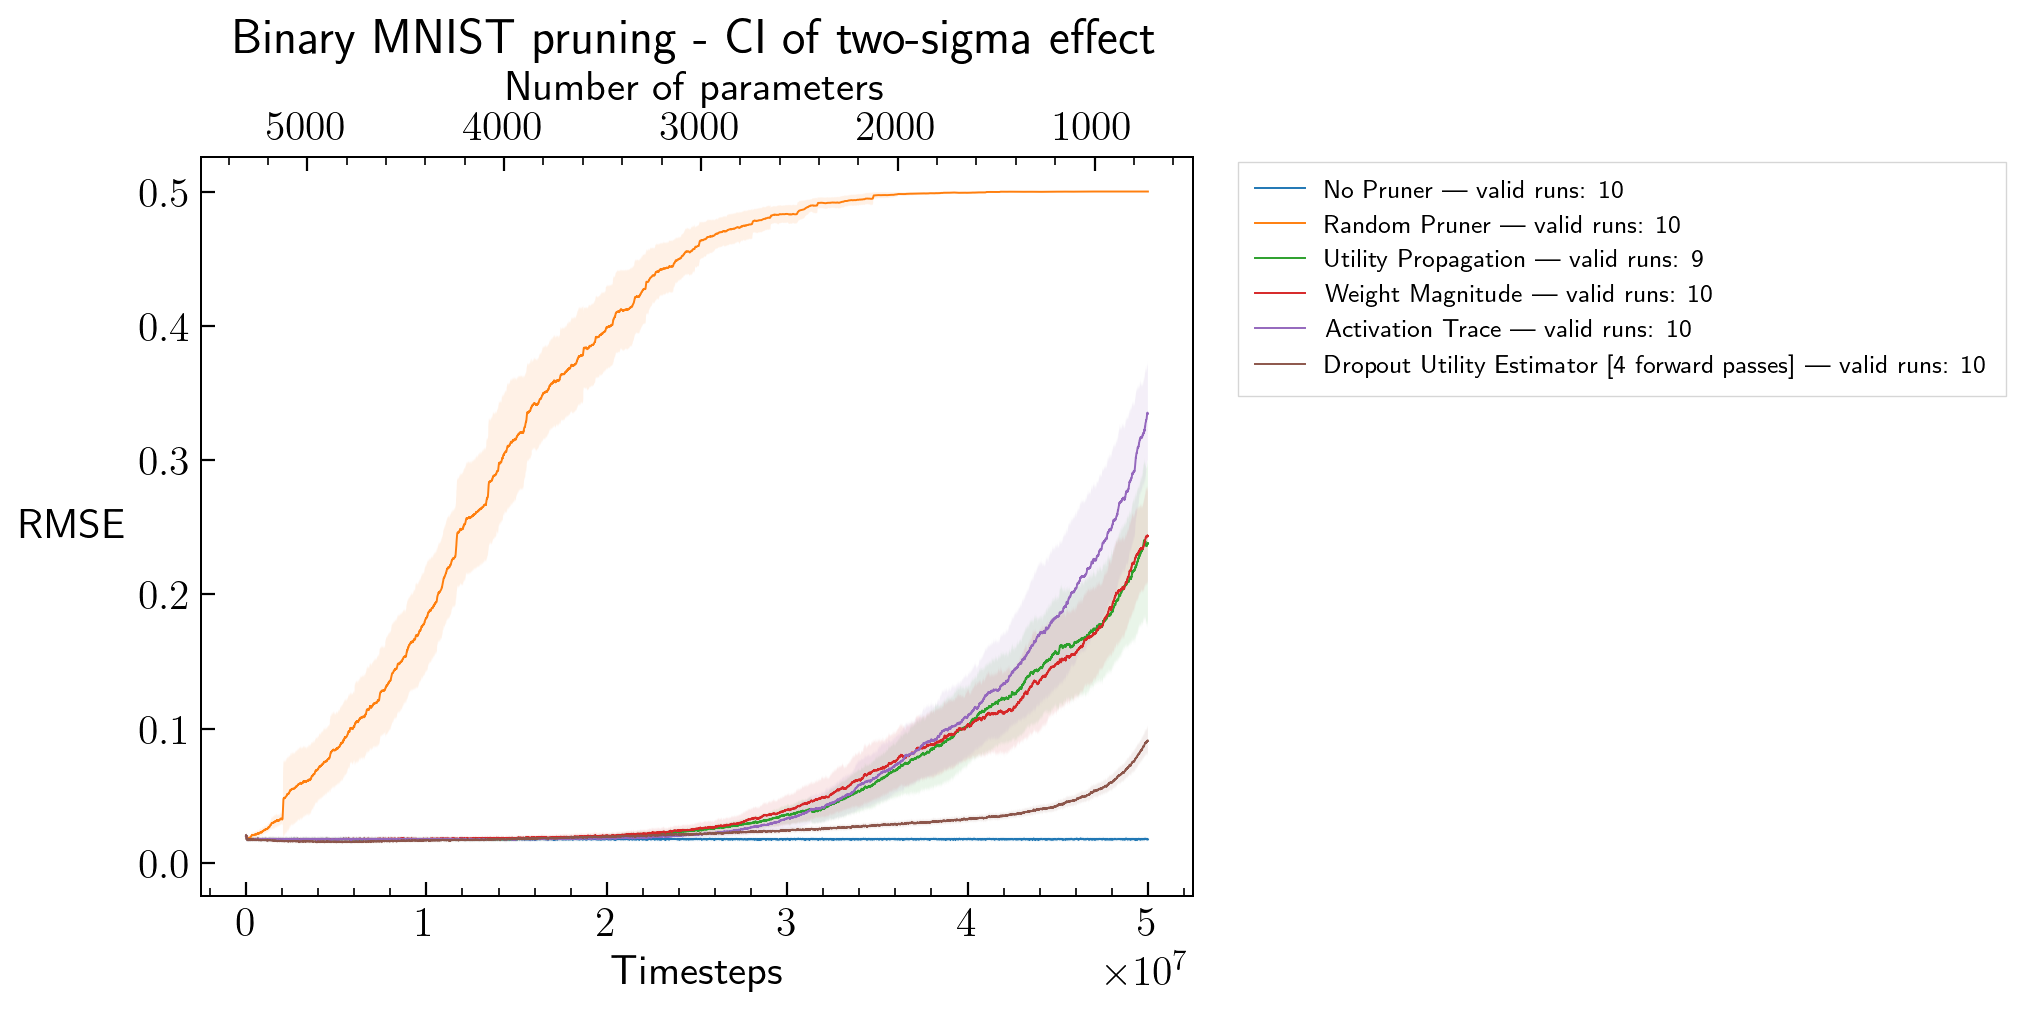

In [13]:

plt_name = f'Binary MNIST pruning - CI of two-sigma effect'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('RMSE', rotation="horizontal", ha="right", ma="center", va="center")
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

linewidth = 0.7
begin_at = 5
smoothing_n = 50
colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
conditions = [["pruner_type", "none"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'No Pruner', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "random"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Random Pruner', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)


color_idx += 1
conditions = [["pruner_type", "utility_propagation"],
              ["trace_decay_rate", 0.99999]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Utility Propagation', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)


color_idx += 1
conditions = [["pruner_type", "weight_magnitude"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Weight Magnitude', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "activation_trace"],
              ["trace_decay_rate", 0.999999]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Activation Trace', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "dropout_utility_estimator"],
              ["dropout_perc", 0.01],
              ["trace_decay_rate", 0.99999],
              ["dropout_estimator_iterations", 4]]

plt_with_err(db3, 
             colors[color_idx], 
             f'Dropout Utility Estimator [4 forward passes]', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")

frame = legend.get_frame()

frame.set_linewidth(0.5)
frame.set_boxstyle('Square')

ax2 = axs.twiny()
ax2.plot(pd.read_sql(f'select param_schedule from error_table where run=0 ', db1.conn).values[begin_at:,0], np.zeros(50000-begin_at), color="None")
ax2.set_xlabel("Number of parameters")
#ax2.xaxis.set_ticks(np.arange(8800, 99, -300))
ax2.minorticks_on()
ax2.set_xlim(left=5540, right=500)
plt.yscale('linear')
#fig.axes[0].set_ylim(top=2.5)
#plt.savefig('figures/plt_err_all_fixed_newl2.svg', bbox_inches='tight', transparent=True)
plt.show()

### same as above but in log scale

	 Found 10 valid runs for [['pruner_type', 'none']]
	 Found 10 valid runs for [['pruner_type', 'random']]
	 Found 9 valid runs for [['pruner_type', 'utility_propagation'], ['trace_decay_rate', 0.99999]]
	 Found 10 valid runs for [['pruner_type', 'weight_magnitude']]
	 Found 10 valid runs for [['pruner_type', 'activation_trace'], ['trace_decay_rate', 0.999999]]
	 Found 10 valid runs for [['pruner_type', 'dropout_utility_estimator'], ['dropout_perc', 0.01], ['trace_decay_rate', 0.99999], ['dropout_estimator_iterations', 4]]


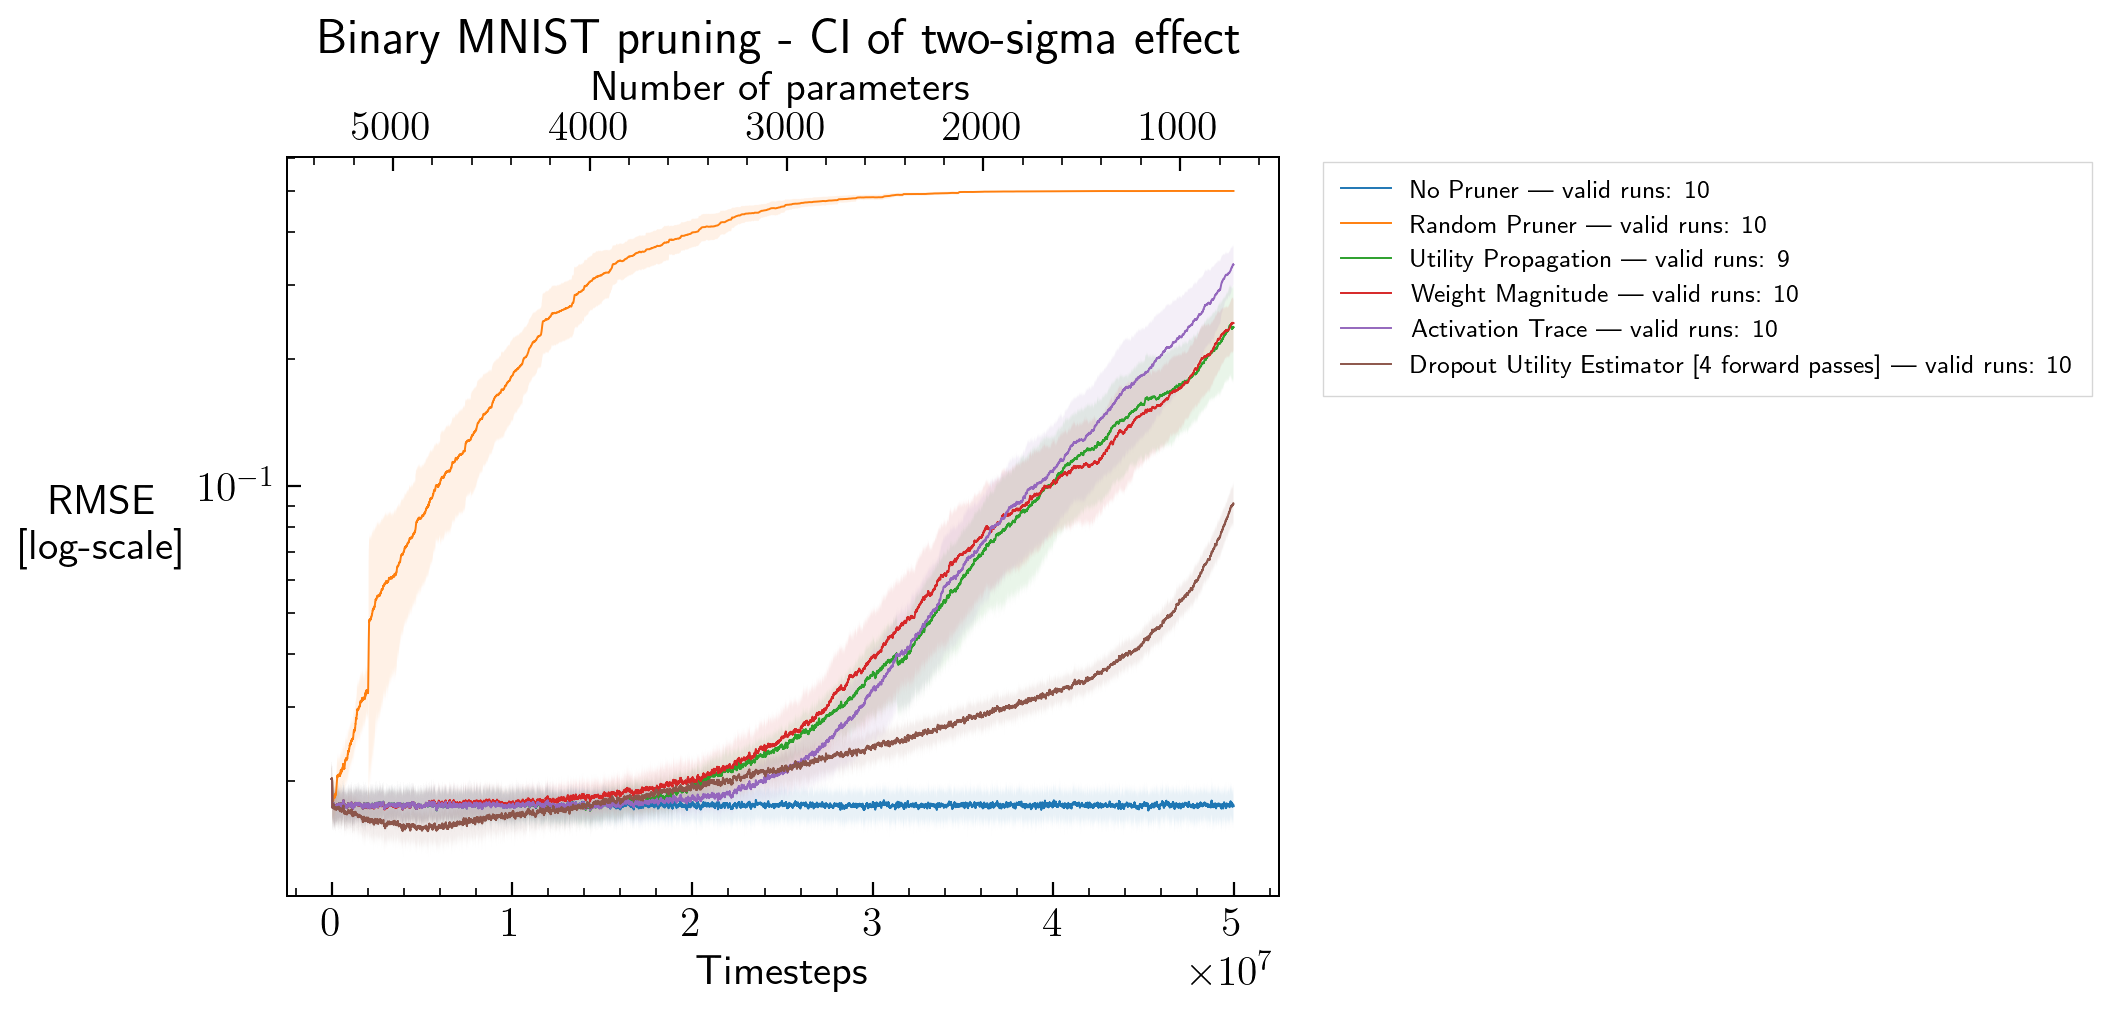

In [14]:

plt_name = f'Binary MNIST pruning - CI of two-sigma effect'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('RMSE \n [log-scale]', rotation="horizontal", ha="right", ma="center", va="center")
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

linewidth = 0.7
begin_at = 5
smoothing_n = 50
colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
conditions = [["pruner_type", "none"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'No Pruner', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "random"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Random Pruner', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)


color_idx += 1
conditions = [["pruner_type", "utility_propagation"],
              ["trace_decay_rate", 0.99999]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Utility Propagation', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)


color_idx += 1
conditions = [["pruner_type", "weight_magnitude"]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Weight Magnitude', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "activation_trace"],
              ["trace_decay_rate", 0.999999]]
plt_with_err(db1, 
             colors[color_idx], 
             f'Activation Trace', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

color_idx += 1
conditions = [["pruner_type", "dropout_utility_estimator"],
              ["dropout_perc", 0.01],
              ["trace_decay_rate", 0.99999],
              ["dropout_estimator_iterations", 4]]

plt_with_err(db3, 
             colors[color_idx], 
             f'Dropout Utility Estimator [4 forward passes]', 
             conditions, 
             "error_table", 
             plot_conf=True, 
             linewidth=linewidth, 
             linestyle="-", 
             smoothing_n=smoothing_n, 
             begin_at=begin_at)

legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")

frame = legend.get_frame()

frame.set_linewidth(0.5)
frame.set_boxstyle('Square')

ax2 = axs.twiny()
ax2.plot(pd.read_sql(f'select param_schedule from error_table where run=0 ', db1.conn).values[begin_at:,0], np.zeros(50000-begin_at), color="None")
ax2.set_xlabel("Number of parameters")
#ax2.xaxis.set_ticks(np.arange(8800, 99, -300))
ax2.minorticks_on()
ax2.set_xlim(left=5540, right=500)
plt.yscale('log')
#fig.axes[0].set_ylim(top=2.5)
#plt.savefig('figures/plt_err_all_fixed_newl2.svg', bbox_inches='tight', transparent=True)
plt.show()